## Data Prepare & Labeled

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
sample_df = pd.read_excel('dataset/sample_1000.xlsx')
sample_df['category'] = sample_df['情感倾向'].apply(lambda x: 'O' if x == '其他' else x)

In [4]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer,pipeline

model = AutoModelForSequenceClassification.from_pretrained('uer/roberta-base-finetuned-dianping-chinese')
tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-dianping-chinese')
text_classification = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

### split data

In [24]:
import numpy as np

df_train, df_val, df_test = np.split(
    sample_df.sample(frac=1, random_state=42),
    [int(0.8 * len(sample_df)), int(0.9 * len(sample_df))],
)

In [25]:
pred = []
for _, row in df_test.iterrows():
    pred.append(text_classification((str(row["title"]) + " " + str(row["content"]))[:513]))

In [39]:
pred = pd.Series([1 if 'positive' in p[0]['label'] else 0 for p in pred])
pred

0     1
1     1
2     0
3     1
4     1
     ..
95    1
96    1
97    1
98    1
99    1
Length: 100, dtype: int64

In [40]:
true = df_test.reset_index(drop=True)['category'].apply(lambda x: 1 if x == 'P' else 0)
true

0     1
1     1
2     0
3     1
4     1
     ..
95    1
96    1
97    1
98    1
99    1
Name: category, Length: 100, dtype: int64

In [42]:
from sklearn.metrics import classification_report
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.40      0.57      0.47         7
           1       0.97      0.94      0.95        93

    accuracy                           0.91       100
   macro avg       0.68      0.75      0.71       100
weighted avg       0.93      0.91      0.92       100



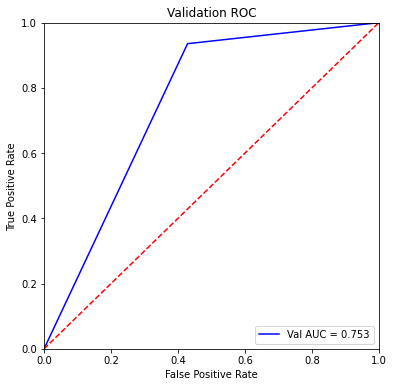

In [43]:
from sklearn import metrics
import pylab as plt

fpr, tpr, threshold = metrics.roc_curve(true, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()